<a href="https://colab.research.google.com/github/Jae1Yoon/transformercopypractice/blob/master/transformerPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **※ Pip install**

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 4.6MB/s 


## **※ import하기**

In [ ]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import sentencepiece as spm

import torch
import torch.nn as nn
import torch.nn.functional as F

# **※ Vocab(kowiki model) 로딩 후 입력**



In [ ]:
# vocab loading
vocab_file = "/content/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

In [ ]:
# 입력 texts
lines = [
  "겨울은 추워요.",
  "감기 조심하세요."
]

In [ ]:
# text를 tensor로 변환
inputs = []
for line in lines:
  pieces = vocab.encode_as_pieces(line)
  ids = vocab.encode_as_ids(line)
  inputs.append(torch.tensor(ids))
  print(pieces)

['▁겨울', '은', '▁추', '워', '요', '.']
['▁감', '기', '▁조', '심', '하', '세', '요', '.']


In [ ]:
# 입력 길이가 다르므로 입력 최대 길이에 맟춰 padding(0)을 추가 해 줌
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
# shape
print(inputs.size())
# 값
print(inputs)

torch.Size([2, 8])
tensor([[3091, 3604,  206, 3958, 3760, 3590,    0,    0],
        [ 212, 3605,   53, 3832, 3596, 3682, 3760, 3590]])


## **※ Embedding**

In [ ]:
""" input embedding """
n_vocab = len(vocab)                    # vocab count
d_hidn = 128                            # hidden size
nn_emb = nn.Embedding(n_vocab, d_hidn)  # embedding 객체

input_embs = nn_emb(inputs)             # input embedding
print(input_embs.size())

torch.Size([2, 8, 128])


# **< input embedding >**
- n_vocab : number of vocab?
- d_hidn : hidden layer의 dimension
>
- **torch.nn.Embedding**
 - https://pytorch.org/docs/master/generated/torch.nn.Embedding.html#torch.nn.Embedding
 - torch.nn.Embedding(**num_embeddings: int**, **embedding_dim: int**, padding_idx: Optional[int] = None, max_norm: Optional[float] = None, norm_type: float = 2.0, scale_grad_by_freq: bool = False, sparse: bool = False, _weight: Optional[torch.Tensor] = None)
 >
 - 앞의 두 인자만 필수, 나머지는 optional한 인자들
 - num_embeddings : 임베딩의 단어 갯수
 - embedding_dim : 임베딩 벡터의 dimension
 >
 - "This module is often used to store word embeddings and retrieve them using indices. The input to the module is a list of indices, and the output is the corresponding word embeddings."
 - 한 마디로 몇 가지 인자들을 입력으로 받아, 그에 해당하는 word embedding이 출력으로 나온다는 이야기. "입력 token을 vector의 형태로 변환한다"는 말이 이런 의미였음. 그리고 위 함수의 결과로 나온 word embedding 벡터가 nn_embs에 저장되는 것.
>
- inputs의 size가 (2, 8)이면 이에 대한 embedding값은 d_hidn을 반영해 (2, 8, 128)이 된다.

In [ ]:
""" sinusoid position embedding : position encoding """
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return sinusoid_table

# **< position encoding >**
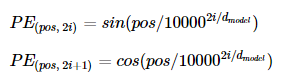
- trasformer는 위치 정보를 가진 값을 만들기 위해 위의 두 함수를 사용한다.
 - ( pos : input sentence 내 embedding vector의 위치
 - i : embedding vector 내 dimesion의 index
 - d_model : 입출력 layer의 dimension. 즉, 정해진 입출력의 크기. )
- 이 3가지 정보를 이용해 angle값을 구하고, embedding vector의 dimension의 index가 짝수이면 sin함수를, 홀수이면 cos함수를 사용한다.
- 위의 cal_angle과 get_posi_angle_vec은 괄호 안의 계산 내용이다. 그 결과를 sinusoid_table에 저장했다.
- 이후 index가 짝수면 sine, 홀수면 cosine을 해준 뒤 반환함으로써 완료된다.

(64, 128)


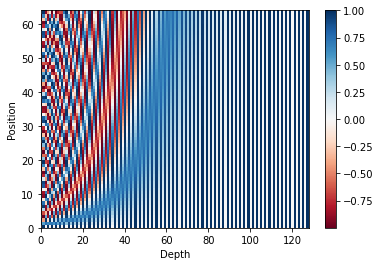

In [ ]:
n_seq = 64
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)

print (pos_encoding.shape) # 크기 출력
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()

n_seq : sequence의 크기?
>
그렇게 position encoding 값을 구하는 과정.
>
>





In [ ]:
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
pos_mask = inputs.eq(0)

positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions) # position embedding

print(inputs)
print(positions)
print(pos_embs.size())

tensor([[3091, 3604,  206, 3958, 3760, 3590,    0,    0],
        [ 212, 3605,   53, 3832, 3596, 3682, 3760, 3590]])
tensor([[1, 2, 3, 4, 5, 6, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]])
torch.Size([2, 8, 128])


**torch.FloatTensor** : 32비트 float 데이터형으로 바꿔준다.
>
**nn.Embedding.from_pretained** : 입력받은 2D floatTensor에 대한 Embedding instance 생성
- https://pytorch.org/docs/master/generated/torch.nn.Embedding.html#torch.nn.Embedding
- CLASSMETHOD from_pretrained(**embeddings**, freeze=True, padding_idx=None, max_norm=None, norm_type=2.0, scale_grad_by_freq=False, sparse=False)
>
 - embeddings 인자 외에 나머지는 전부 optional이다.
 - embeddings : embedding에 대한 가중치를 포함한 FloatTensor. 2D 중 첫 번째는 임베딩 갯수로, 두 번째는 임베딩 벡터의 차원으로 전달된다.
 - freeze : True로 설정될 경우, 해당 tensor는 학습 절차 중에 update되지 않는다.
>

**torch.arange** : (end - start) / step 크기의, start부터 시작해서 end에 이르기까지 step만큼 건너뛰는 값들을 가진 1D tensor를 리턴한다. 
- torch.arange(**start=0**, **end**, **step=1**, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) → Tensor
- https://pytorch.org/docs/master/generated/torch.arange.html#torch.arange
 - start, end, step 外 나머지는 모두 optional하다.
 - start, end, step : start = 0, step = 1로 default값 설정되어 있어서 위 코드처럼 인자 하나만 받는 경우 end로 들어가는 듯. 
 - dtype : return 받을 tensor의 데이터형
 - device : return 받을 tensor의 device
 - requires_grad : autograd가 받을 tensor의 모든 연산을 추적할지 여부 (autograd : '자동 미분' framework으로, requires_grad가 true면 연산 추적 종료 이후에 역방향으로 모든 gradient를 자동 계산한다.) https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html
>
 - ※ 그런데 arange 뒤에 위치하는 'expand'는 tensor의 dimension size를 늘려주는 기능이고, 'contiguous'는 tensor와 같은 data를 가진 메모리 tensor의 contiguous?를 리턴한다. 인자가 default일 경우 memory format을 contiguous_format으로 한다는데 이해를 못했다. ( 참고 : https://pytorch.org/docs/stable/tensors.html )

>
아무튼 이 arange 함수에 inputs의 size를 대입함으로써 positions를 만들고,
>
pos_mask 변수에 inputs 中 값이 0인 부분을 저장해 그대로 positions에 해당 부분을 masking 처리해준다.
>
이 처리과정까지 완료된 positions 정보를 임베딩 인스턴스화함으로써 최종적으로 **position embedding**이 완성되는 것이다.



In [ ]:
input_sums = input_embs + pos_embs

그리고 input embedding과 position embedding을 더해주면 input은 끝.

## **※ Scaled Dot Product Attention**

In [ ]:
""" input """
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_mask.size())
print(attn_mask[0])

torch.Size([2, 8, 8])
tensor([[False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True]])


Encoder의 self-attention, Decoder의 self-attention 모두 Q = K = V다.
>
Decoder의 Encoder-Decoder attention만 Q from Decoder vector, K = V from Encoder vector다. 그렇다구요~ 깔! 깔! 깔~
>
**unsqueeze** : '지정된 위치'에 삽입된 크기 1의 dimension을 가진 새로운 tensor를 리턴한다.
>
아무튼 inputs에 값이 공백인 부분을 찾아, 추후 해당 부분은 attention의 전체 연산 과정에서 제외시키기 위한 attention mask 변수에 넣는다.

In [ ]:
""" Q * K-transpose """
scores = torch.matmul(Q, K.transpose(-1, -2))
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[203.3360,  68.0523,  80.2481,  62.1185,  95.7974,  59.2111,  48.6162,
          48.6162],
        [ 68.0523, 223.8689,  77.6710,  92.3771,  69.2858,  47.9890,  62.1625,
          62.1625],
        [ 80.2481,  77.6710, 208.6642,  79.4435,  60.1847,  66.8837,  70.7589,
          70.7589],
        [ 62.1185,  92.3771,  79.4435, 189.3903,  70.9870,  27.5476,  39.7176,
          39.7176],
        [ 95.7974,  69.2858,  60.1847,  70.9870, 199.4789,  72.5259,  41.4736,
          41.4736],
        [ 59.2111,  47.9890,  66.8837,  27.5476,  72.5259, 176.7278,  30.3802,
          30.3802],
        [ 48.6162,  62.1625,  70.7589,  39.7176,  41.4736,  30.3802, 189.9152,
         189.9152],
        [ 48.6162,  62.1625,  70.7589,  39.7176,  41.4736,  30.3802, 189.9152,
         189.9152]], grad_fn=<SelectBackward>)


Q와 K의 전치matrix를 matmul시켜주는 과정. K를 전치할 때 들어가는 인자 -1, -2의 의미는 잘 모르겠음.

In [ ]:
""" scale """
d_head = 64
scores = scores.mul_(1/d_head**0.5)
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[25.4170,  8.5065, 10.0310,  7.7648, 11.9747,  7.4014,  6.0770,  6.0770],
        [ 8.5065, 27.9836,  9.7089, 11.5471,  8.6607,  5.9986,  7.7703,  7.7703],
        [10.0310,  9.7089, 26.0830,  9.9304,  7.5231,  8.3605,  8.8449,  8.8449],
        [ 7.7648, 11.5471,  9.9304, 23.6738,  8.8734,  3.4435,  4.9647,  4.9647],
        [11.9747,  8.6607,  7.5231,  8.8734, 24.9349,  9.0657,  5.1842,  5.1842],
        [ 7.4014,  5.9986,  8.3605,  3.4435,  9.0657, 22.0910,  3.7975,  3.7975],
        [ 6.0770,  7.7703,  8.8449,  4.9647,  5.1842,  3.7975, 23.7394, 23.7394],
        [ 6.0770,  7.7703,  8.8449,  4.9647,  5.1842,  3.7975, 23.7394, 23.7394]],
       grad_fn=<SelectBackward>)


**d_head** : 입출력의 dimension을 병렬 갯수로 나눈 값인데, 여기서는 128과 2이므로 64라고 선언한듯.
>
바로 위의 Q * K-transpose를 이 d_head의 root값으로 나눠주는 scale 과정이다.

In [ ]:
""" mask (optional) """
scores.masked_fill_(attn_mask, -1e9)
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[ 2.5417e+01,  8.5065e+00,  1.0031e+01,  7.7648e+00,  1.1975e+01,
          7.4014e+00, -1.0000e+09, -1.0000e+09],
        [ 8.5065e+00,  2.7984e+01,  9.7089e+00,  1.1547e+01,  8.6607e+00,
          5.9986e+00, -1.0000e+09, -1.0000e+09],
        [ 1.0031e+01,  9.7089e+00,  2.6083e+01,  9.9304e+00,  7.5231e+00,
          8.3605e+00, -1.0000e+09, -1.0000e+09],
        [ 7.7648e+00,  1.1547e+01,  9.9304e+00,  2.3674e+01,  8.8734e+00,
          3.4435e+00, -1.0000e+09, -1.0000e+09],
        [ 1.1975e+01,  8.6607e+00,  7.5231e+00,  8.8734e+00,  2.4935e+01,
          9.0657e+00, -1.0000e+09, -1.0000e+09],
        [ 7.4014e+00,  5.9986e+00,  8.3605e+00,  3.4435e+00,  9.0657e+00,
          2.2091e+01, -1.0000e+09, -1.0000e+09],
        [ 6.0770e+00,  7.7703e+00,  8.8449e+00,  4.9647e+00,  5.1842e+00,
          3.7975e+00, -1.0000e+09, -1.0000e+09],
        [ 6.0770e+00,  7.7703e+00,  8.8449e+00,  4.9647e+00,  5.1842e+00,
          3.7975e+00, -1.0000e+09, -1.0000e

위에서도 언급했듯 아까 구한 attention mask를 매우 작은 값으로 바꿔 연산에서 제외시킨다.

In [ ]:
""" softmax """
attn_prob = nn.Softmax(dim=-1)(scores)
print(attn_prob.size())
print(attn_prob[0])

torch.Size([2, 8, 8])
tensor([[1.0000e+00, 4.5277e-08, 2.0795e-07, 2.1565e-08, 1.4524e-06, 1.4994e-08,
         0.0000e+00, 0.0000e+00],
        [3.4771e-09, 1.0000e+00, 1.1571e-08, 7.2733e-08, 4.0568e-09, 2.8317e-10,
         0.0000e+00, 0.0000e+00],
        [1.0683e-07, 7.7410e-08, 1.0000e+00, 9.6610e-08, 8.7001e-09, 2.0100e-08,
         0.0000e+00, 0.0000e+00],
        [1.2326e-07, 5.4133e-06, 1.0748e-06, 9.9999e-01, 3.7347e-07, 1.6371e-09,
         0.0000e+00, 0.0000e+00],
        [2.3521e-06, 8.5552e-08, 2.7426e-08, 1.0582e-07, 1.0000e+00, 1.2827e-07,
         0.0000e+00, 0.0000e+00],
        [4.1724e-07, 1.0261e-07, 1.0887e-06, 7.9704e-09, 2.2040e-06, 1.0000e+00,
         0.0000e+00, 0.0000e+00],
        [4.3100e-02, 2.3435e-01, 6.8632e-01, 1.4171e-02, 1.7649e-02, 4.4106e-03,
         0.0000e+00, 0.0000e+00],
        [4.3100e-02, 2.3435e-01, 6.8632e-01, 1.4171e-02, 1.7649e-02, 4.4106e-03,
         0.0000e+00, 0.0000e+00]], grad_fn=<SelectBackward>)


https://pytorch.org/docs/master/generated/torch.nn.Softmax.html#torch.nn.Softmax
>
에 의하면 파라미터인 dim은 softmax 연산이 진행될 dimension을 의미하는데 dim이 -1일 수 있나? 노이해인 부분.
>
아무튼 결과를 보면 mask 부분은 전부 0이 되었다.

In [ ]:
""" attention prov * V """
context = torch.matmul(attn_prob, V)
print(context.size())

torch.Size([2, 8, 128])


softmax까지 해서 나온 녀석과 V 벡터를 matmul해주는 과정.

In [ ]:
""" implementation CLASS : bind all of those things """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.scale = 1 / (d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

하나의 CLASS로 합친 것. 위의 과정들이 빠짐 없이 들어있다.

## **※ Multi-Head Attention**

In [ ]:
""" input """
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))

batch_size = Q.size(0)
n_head = 2

input 정보는 위의 scaled attention과 같다. 여기선 head 개수를 2로 지정했군. 논문에선 8이다.

In [ ]:
""" Multi Head Q, K, V """
W_Q = nn.Linear(d_hidn, n_head * d_head)
W_K = nn.Linear(d_hidn, n_head * d_head)
W_V = nn.Linear(d_hidn, n_head * d_head)

# (bs, n_seq, n_head * d_head)
q_s = W_Q(Q)
print(q_s.size())
# (bs, n_seq, n_head, d_head)
q_s = q_s.view(batch_size, -1, n_head, d_head)
print(q_s.size())
# (bs, n_head, n_seq, d_head)
q_s = q_s.transpose(1,2)
print(q_s.size())

torch.Size([2, 8, 128])
torch.Size([2, 8, 2, 64])
torch.Size([2, 2, 8, 64])


**nn.Linear** : 곧 들어오는 input data에 y = x*A-transpose + B linear transformation 연산을 적용한다.
- https://pytorch.org/docs/master/generated/torch.nn.Linear.html#torch.nn.Linear
- torch.nn.Linear(**in_features**: int, **out_features**: int, **bias**: bool = True)
 - in_features : 각 input sample의 size
 - out_features : 각 output sample의 size
 - bias : false면 추가 bias를 학습 안 함. default값은 true.

**view** : tensor를 입력받은 파라미터대로 다른 shape의 tensor로 바꿔주는 역할.

즉 가중치 행렬을 만들어 linear transformation을 진행한 뒤 view를 통해 병렬화한다.



In [ ]:
# (bs, n_head, n_seq, d_head)
q_s = W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1,2)
# (bs, n_head, n_seq, d_head)
k_s = W_K(K).view(batch_size, -1, n_head, d_head).transpose(1,2)
# (bs, n_head, n_seq, d_head)
v_s = W_V(V).view(batch_size, -1, n_head, d_head).transpose(1,2)
print(q_s.size(), k_s.size(), v_s.size())

torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64])


바로 위의 과정을 Q, K, V 각각에 적용해준 code.

In [ ]:
""" Multi Head Attention Mask """
print(attn_mask.size())
attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1)
print(attn_mask.size())

torch.Size([2, 8, 8])
torch.Size([2, 2, 8, 8])


attention mask도 같은 형식의 multi head로 만들어준다.

In [ ]:
""" Attention """
scaled_dot_attn = ScaledDotProductAttention(d_head)
context, attn_prob = scaled_dot_attn(q_s, k_s, v_s, attn_mask)
print(context.size())
print(attn_prob.size())

torch.Size([2, 2, 8, 64])
torch.Size([2, 2, 8, 8])


scaled dot product attention 어서오고 ㅋㅋ

In [ ]:
""" Concat """
# (bs, n_seq, n_head * d_head)
context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_head * d_head)
print(context.size())

torch.Size([2, 8, 128])


concat 갈겨주고

In [ ]:
""" Linear """
linear = nn.Linear(n_head * d_head, d_hidn)
# (bs, n_seq, d_hidn)
output = linear(context)
print(output.size())

torch.Size([2, 8, 128])


linear transformation 딱 대주고.

In [ ]:
""" implementation CLASS : bind all those things """
class MultiHeadAttention(nn.Module):
    def __init__(self, d_hidn, n_head, d_head):
        super().__init__()
        self.d_hidn = d_hidn
        self.n_head = n_head
        self.d_head = d_head

        self.W_Q = nn.Linear(d_hidn, n_head * d_head)
        self.W_K = nn.Linear(d_hidn, n_head * d_head)
        self.W_V = nn.Linear(d_hidn, n_head * d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(d_head)
        self.linear = nn.Linear(n_head * d_head, d_hidn)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

CLASS로 합쳐서 표현하면 이렇고 ㅋㅋ

## **※ Feed Forward NN**
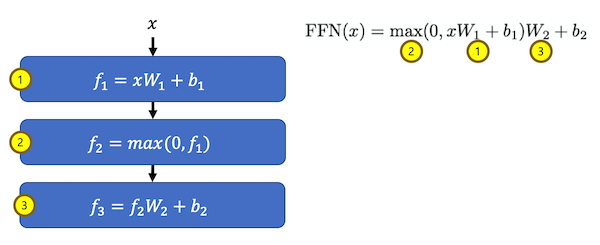

In [ ]:
""" f1 (Linear) """
conv1 = nn.Conv1d(in_channels=d_hidn, out_channels=d_hidn * 4, kernel_size=1)
# (bs, d_hidn * 4, n_seq)
ff_1 = conv1(output.transpose(1, 2))
print(ff_1.size())

torch.Size([2, 512, 8])


1d로 conv 적용해주고

In [ ]:
""" Activation (Relu or Gelu) """
# active = F.relu
active = F.gelu
ff_2 = active(ff_1)

gelu를 사용해주는 swag

In [ ]:
""" f3 (Linear) """
conv2 = nn.Conv1d(in_channels=d_hidn * 4, out_channels=d_hidn, kernel_size=1)
ff_3 = conv2(ff_2).transpose(1, 2)
print(ff_3.size())

torch.Size([2, 8, 128])


1d conv 적용해주면 끝.

In [ ]:
""" implementation CLASS : bind all those things """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_hidn):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_hidn * 4, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_hidn * 4, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        # (bs, n_seq, d_hidn)
        return output

CLASS 하나로 나타내면 다음과 같다.